In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from attributes import *

#here we import X features of dataset
atts = atts_giveme

ModuleNotFoundError: No module named 'attributes'

In [2]:
#here we read datasets
df = pd.read_pickle('GiveMe_train.pkl')
df_test = pd.read_pickle('GiveMe_test.pkl')
df_test['age'] = df_test['age'].astype(float)
df_test = df_test.reset_index()

In [3]:
lgb.LGBMClassifier(random_state=42, n_jobs=2).__class__.__name__

'LGBMClassifier'

In [3]:
#here we split train and hold set
df_train, df_hold = train_test_split(df, stratify=df['TARGET'], random_state=42, test_size=.1)
df_train = df_train.reset_index()
df_hold = df_hold.reset_index()


In [4]:
#here we train the first classifier f over training set 
clf_base = lgb.LGBMClassifier(random_state=42, n_jobs=2)
clf_base.fit(df_train[atts], df_train['TARGET'])

LGBMClassifier(n_jobs=2, random_state=42)

here we compute scores and errors as $|y-s(X)|$, where $s(X) \sim P(y=1|X)$ over holdout set

In [5]:
df_hold['scores'] = clf_base.predict_proba(df_hold[atts])[:,1]
df_hold['err'] = np.fabs(df_hold['TARGET']-df_hold['scores'])

here we plot errors distrbution over holdout

(array([9084.,  814.,  301.,  216.,  141.,  128.,  109.,   93.,  121.,
         243.]),
 array([0.00143706, 0.10107543, 0.2007138 , 0.30035218, 0.39999055,
        0.49962892, 0.5992673 , 0.69890567, 0.79854404, 0.89818242,
        0.99782079]),
 <BarContainer object of 10 artists>)

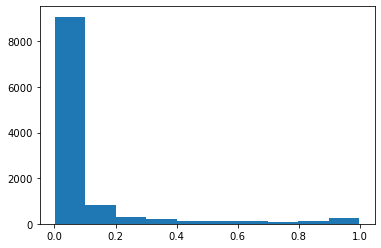

In [6]:
import matplotlib.pyplot as plt
plt.hist(df_hold['err'])

here we compute shapley values $\phi(X_{hold})$ over holdout set

>If you want to get more explanations for your model’s predictions using SHAP values, like SHAP interaction values, you can install the shap package (https://github.com/slundberg/shap). Note that unlike the shap package, with pred_contrib we return a matrix with an extra column, where the last column is the expected value.

In [7]:
cols = ['shap_{}'.format(col) for col in df_hold[atts].columns]
shaps = pd.DataFrame(clf_base.predict(df_hold[atts], pred_contrib=True)[:,:-1], columns = cols)
shaps['err'] = df_hold['err'].copy()

here we define our low-high error for acceptance (if error below a certain threshold depending on target coverage we accept the instance, otherwise reject)

In [8]:
quantile = .8
theta = np.quantile(shaps['err'], quantile)
shaps['ACCEPTED'] = np.where(shaps['err']<theta, 1, 0)


here we build a selector $g:\phi(X) \to \{0,1\}$, which learns when to reject from explanation space;


In [9]:
g = lgb.LGBMClassifier(random_state=42)
g.fit(shaps[cols], shaps['ACCEPTED'])

LGBMClassifier(random_state=42)

here we test over a test set whether selected instances according to the selector g increase performances

In [10]:
shaps_test = pd.DataFrame(clf_base.predict(df_test[atts], pred_contrib=True)[:,:-1], columns = cols)
scores = clf_base.predict_proba(df_test[atts])[:, 1]
# shaps_test['err'] = np.fabs(df_test['TARGET']-scores)
# shaps_test['ACCEPTED'] = np.where(shaps_test['err']<theta, 1, 0)

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score

preds = clf_base.predict(df_test[atts])
selected = g.predict(shaps_test[cols]).astype(bool)
print("roc auc score full sample")
print(roc_auc_score(df_test['TARGET'], scores))
print("roc auc score selected")
print(roc_auc_score(df_test[selected]['TARGET'], scores[selected]))
print("accuracy full sample")
print(accuracy_score(df_test['TARGET'], preds))
print("accuracy selected")
print(accuracy_score(df_test[selected]['TARGET'], preds[selected]))
print("coverage selected")
print(selected.sum()/len(selected))
# roc_auc_score(shaps_test['ACCEPTED'], g.predict_proba(shaps_test[cols])[:,1])

roc auc score full sample
0.8660279853698326
roc auc score selected
0.7539643775004781
accuracy full sample
0.93696
accuracy selected
0.9750990195441854
coverage selected
0.8213866666666667


Testing over multiple coverages

In [12]:
def test(shaps_train, shaps_test, df_test, atts, clf_base,  list_coverages):
    for quantile in list_coverages:
        theta = np.quantile(shaps['err'], quantile)
        print("target coverage is {}\n\n\n".format(quantile))
        shaps_train['ACCEPTED'] = np.where(shaps_train['err']<theta, 1, 0)
#         if (abs(1-quantile)<=.1):
#             g = lgb.LGBMClassifier(random_state=42, is_unbalance=True)
#         else:
        g = lgb.LGBMClassifier(random_state=42)
        g.fit(shaps[cols], shaps['ACCEPTED'])
        shaps_test = pd.DataFrame(clf_base.predict(df_test[atts], pred_contrib=True)[:,:-1], columns = cols)
        scores = clf_base.predict_proba(df_test[atts])[:, 1]
        preds = clf_base.predict(df_test[atts])
        selected = g.predict(shaps_test[cols]).astype(bool)
        print("roc auc score full sample")
        print(roc_auc_score(df_test['TARGET'], scores))
        print("roc auc score selected")
        print(roc_auc_score(df_test[selected]['TARGET'], scores[selected]))
        print("accuracy full sample")
        print(accuracy_score(df_test['TARGET'], preds))
        print("accuracy selected")
        print(accuracy_score(df_test[selected]['TARGET'], preds[selected]))
        print("coverage selected")
        print(selected.sum()/len(selected))
        print("\n")

In [13]:
list_coverages = [ .99, .95, .9, .85, .8, .75]
test(shaps, shaps_test, df_test, atts, clf_base,  list_coverages)

target coverage is 0.99



roc auc score full sample
0.8660279853698326
roc auc score selected
0.8660313774880833
accuracy full sample
0.93696
accuracy selected
0.9369448667680244
coverage selected
0.99976


target coverage is 0.95



roc auc score full sample
0.8660279853698326
roc auc score selected
0.8655420869678144
accuracy full sample
0.93696
accuracy selected
0.9378446383639382
coverage selected
0.9962133333333333


target coverage is 0.9



roc auc score full sample
0.8660279853698326
roc auc score selected
0.8043184495080592
accuracy full sample
0.93696
accuracy selected
0.9604545715433622
coverage selected
0.9292266666666666


target coverage is 0.85



roc auc score full sample
0.8660279853698326
roc auc score selected
0.7645723660371213
accuracy full sample
0.93696
accuracy selected
0.9705730354157167
coverage selected
0.8772


target coverage is 0.8



roc auc score full sample
0.8660279853698326
roc auc score selected
0.7539643775004781
accuracy full sample
0.93696
accura